# Reconvolution-based VEP analysis

This notebook reconstructs visual evoked potentials (VEPs) from EEG data using
a reconvolution approach applied to electrode Oz.

Before running:
- Set the `ROOT` path below to your local directory

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import pyntbci
from scipy.stats import ttest_rel

## Load preprocessed EEG data

This analysis uses preprocessed c-VEP data stored as `.npz` files in
`Data/derivatives/`.

In [2]:
ROOT = r"C:\Users\donja\Desktop\Thesis"

DATA_DERIV   = os.path.join(ROOT, "Data", "derivatives")
FIG_DIR = os.path.join(ROOT, "Results")
os.makedirs(FIG_DIR, exist_ok=True)

all_files = sorted(glob.glob(os.path.join(DATA_DERIV, "sub-*", "sub-*_cvep_*.npz")))
print("Found npz files:", len(all_files))

Found npz files: 60


In [3]:
files = [f for f in all_files if "sub-004" not in f]
print("After excluding sub-004:", len(files))

After excluding sub-004: 48


In [4]:
montage = mne.channels.make_standard_montage("biosemi64")
oz_idx = montage.ch_names.index("Oz")
print("Oz index:", oz_idx)

Oz index: 28


In [5]:
def parse_condition(fn):
    base = os.path.basename(fn).replace(".npz", "")
    parts = base.split("_")
    subject = parts[0]
    stim_type = parts[2]
    contrast = int(parts[3])
    return subject, stim_type, contrast

## Reconvolution of visual evoked potentials

VEPs are reconstructed using a reconvolution approach, corresponding to the
first step of rCCA-based decoding.

In [6]:
def build_E_M_from_V(V, fs, encoding_length_s=0.3, event="refe", onset_event=True):
    E, events = pyntbci.utilities.event_matrix(V, event=event, onset_event=onset_event)
    L = int(round(encoding_length_s * fs))
    M = pyntbci.utilities.encoding_matrix(E, L)
    return E, M, events, L

In [7]:
def reconvolve_condition_npz(fn, oz_idx, encoding_length_s=0.3, event="refe", onset_event=True, ridge=1e-12):
    d = np.load(fn, allow_pickle=True)
    X = d["X"]  # (trials, channels, samples)
    y = d["y"]  # (trials,)
    V = d["V"]  # (classes, code_samples)
    fs = int(d["fs"])

    # Common average referencing (CAR)
    X = X - X.mean(axis=1, keepdims=True)
    
    E, M, events, L = build_E_M_from_V(V, fs, encoding_length_s=encoding_length_s, event=event, onset_event=onset_event)

    # Extract Oz
    x_trials = X[:, oz_idx, :]

    n_cycles = x_trials.shape[1] // M.shape[2]

    A_list = []
    x_list = []

    for i in range(x_trials.shape[0]):
        cls = int(y[i])
        M_cls = M[cls] 
        M_full = np.tile(M_cls, (1, n_cycles))  # (features, samples)
        A_list.append(M_full.T)  # (samples, features)
        x_list.append(x_trials[i])  # (samples,)

    A = np.vstack(A_list)          # (trials*samples, features)
    x_cat = np.concatenate(x_list) # (trials*samples,)

    # Ridge regression: r = (A^T A + λI)^-1 A^T x
    AtA = A.T @ A
    Atx = A.T @ x_cat
    r = np.linalg.solve(AtA + ridge*np.eye(AtA.shape[0]), Atx)  

    # Reshape into (n_events, L)
    n_events = E.shape[1]
    r_ev = r.reshape(n_events, L)

    return r_ev, events, fs

In [8]:
rows = []

for fn in files:
    subject, stim_type, contrast = parse_condition(fn)
    r_fall, events, fs = reconvolve_condition_npz(fn, oz_idx=oz_idx, encoding_length_s=0.3, event="fall", onset_event=False, ridge=1e-12)
    rows.append({"subject": subject, "stim_type": stim_type, "contrast": contrast, "fs": fs, "events": events, "r_ev": r_fall})
    
df_vep = pd.DataFrame(rows)
df_vep.head()


,subject,stim_type,contrast,fs,events,r_ev
0,sub-002,classic,10,120,"(fall,)","[[-2.3986323896299094e-07, -8.470011710331643e..."
1,sub-002,classic,100,120,"(fall,)","[[-3.979815324292172e-07, -2.6090012373168995e..."
2,sub-002,classic,20,120,"(fall,)","[[2.466400566833148e-07, 5.514716408147484e-07..."
3,sub-002,classic,30,120,"(fall,)","[[1.921008628070942e-07, 4.840437815615737e-07..."
4,sub-002,classic,40,120,"(fall,)","[[-3.33377080274584e-07, -8.399304343125481e-0..."


## Visualization of reconstructed VEPs

The following plots show reconstructed VEP waveforms for different stimulus
types and contrast levels.

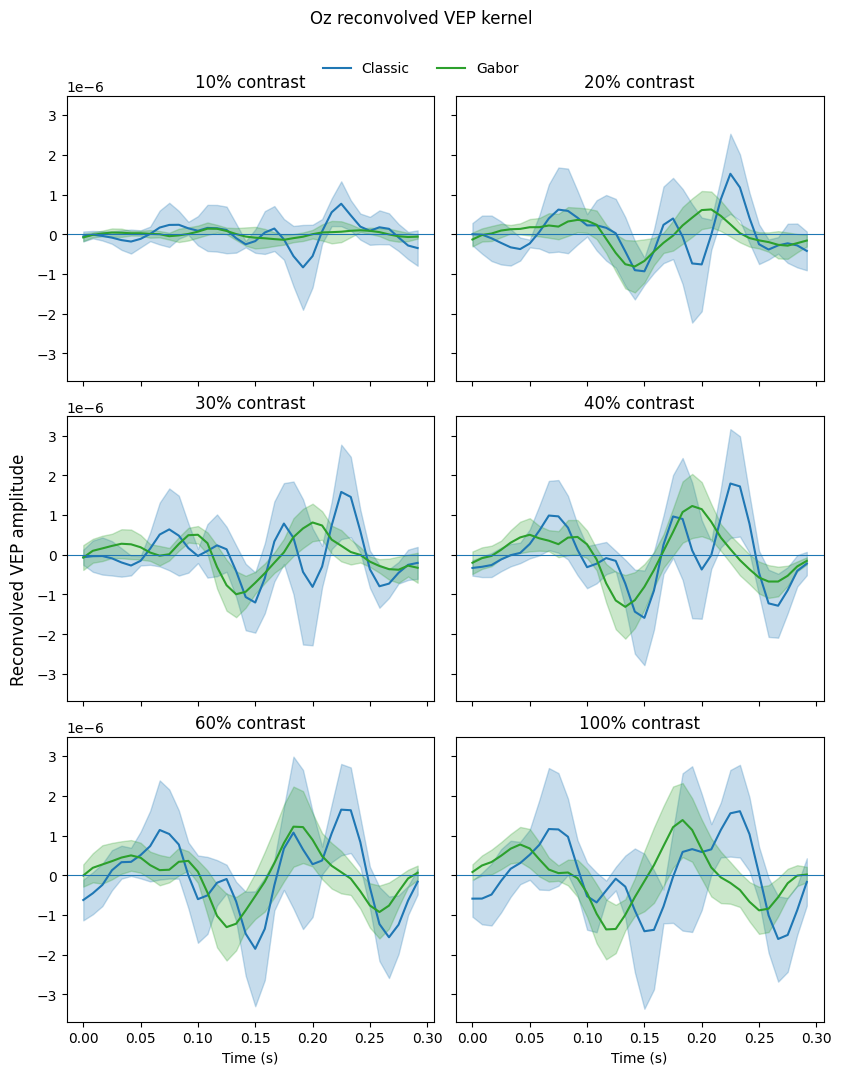

In [9]:
def plot_vep_grid(df_vep, event_idx=0, event_name="rise"):
    contrasts = [10, 20, 30, 40, 60, 100]

    fs = int(df_vep["fs"].iloc[0])
    L = df_vep["r_ev"].iloc[0].shape[1]
    t = np.arange(L) / fs

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8.3, 10), sharex=True, sharey=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, contrast in zip(axes, contrasts):
        sub = df_vep[df_vep["contrast"] == contrast]
        if sub.empty:
            ax.set_visible(False)
            continue

        # Classic
        rs_c = np.stack(sub[sub["stim_type"] == "classic"]["r_ev"].values)
        wave_c = rs_c[:, event_idx, :]
        mean_c = wave_c.mean(axis=0)
        std_c  = wave_c.std(axis=0, ddof=1) if wave_c.shape[0] > 1 else np.zeros_like(mean_c)
        ax.plot(t, mean_c, color="C0", label="Classic")
        ax.fill_between(t, mean_c-std_c, mean_c+std_c, color="C0", alpha=0.25)

        # Gabor
        rs_g = np.stack(sub[sub["stim_type"] == "grating"]["r_ev"].values)
        wave_g = rs_g[:, event_idx, :]
        mean_g = wave_g.mean(axis=0)
        std_g  = wave_g.std(axis=0, ddof=1) if wave_g.shape[0] > 1 else np.zeros_like(mean_g)
        ax.plot(t, mean_g, color="C2", label="Gabor")
        ax.fill_between(t, mean_g-std_g, mean_g+std_g, color="C2", alpha=0.25)

        ax.axhline(0, linewidth=0.8)
        ax.set_title(f"{contrast}% contrast")

    axes[4].set_xlabel("Time (s)")
    axes[5].set_xlabel("Time (s)")

    fig.supylabel("Reconvolved VEP amplitude")

    fig.suptitle(f"Oz reconvolved VEP kernel", y=1.06)

    handles, labels = axes[0].get_legend_handles_labels()

    fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))
    
    plt.savefig(os.path.join(FIG_DIR, "oz_reconvolved_vep.pdf"), bbox_inches="tight")
    plt.show()

plot_vep_grid(df_vep, event_idx=0, event_name="fall")

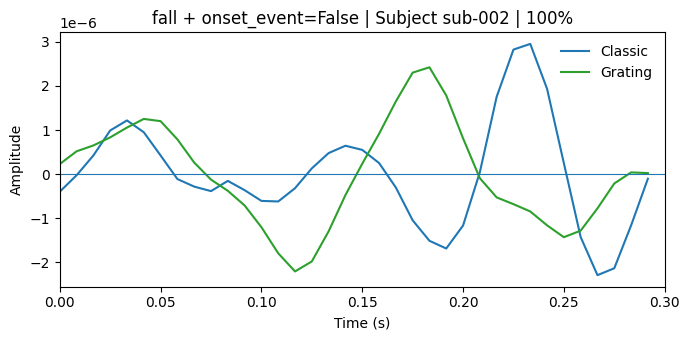

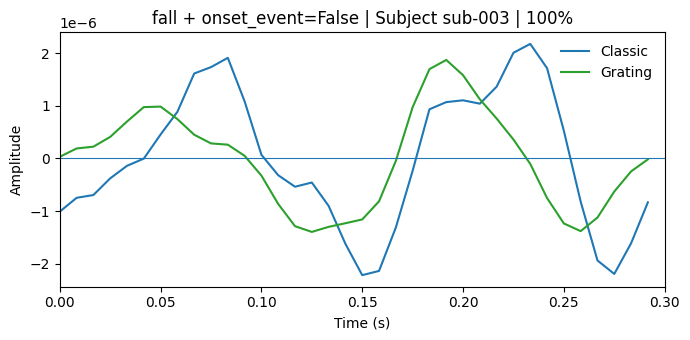

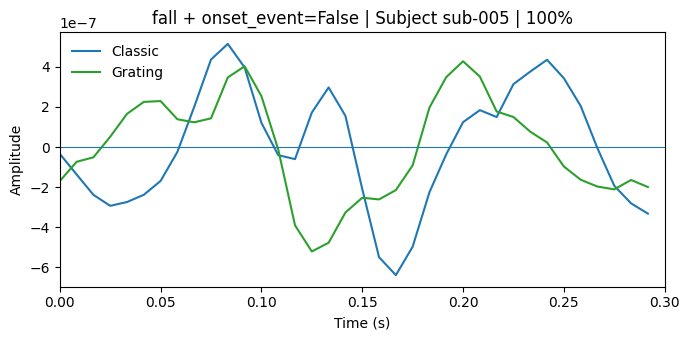

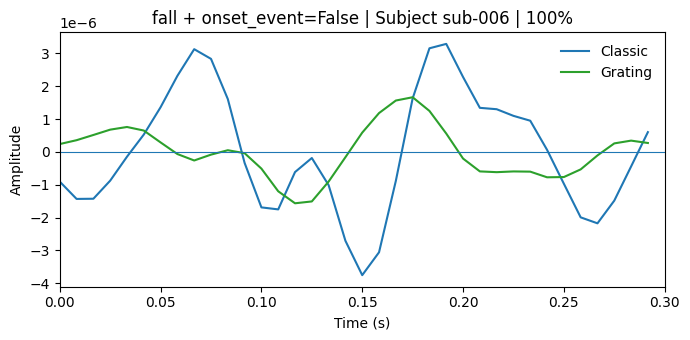

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def to_waveform(r_ev, event_idx=None):
    r = np.asarray(r_ev)
    if r.ndim == 1:
        return r
    if event_idx is not None and r.ndim == 2:
        return r[event_idx, :]
    if event_idx is not None and r.ndim == 3:
        return r[:, event_idx, :].mean(axis=0)
    while r.ndim > 1:
        r = np.nanmean(r, axis=0)
    return r

def plot_subjects(df_vep, contrast=100, event_idx=None, xlim=(0, 0.30), title_prefix=""):
    dfc = df_vep[df_vep["contrast"] == contrast].copy()
    if dfc.empty:
        raise ValueError(f"No rows for contrast={contrast}")

    fs = int(dfc["fs"].iloc[0])
    T = to_waveform(dfc["r_ev"].iloc[0], event_idx=event_idx).shape[0]
    t = np.arange(T) / fs

    subjects = sorted(dfc["subject"].unique())

    for subj in subjects:
        sdf = dfc[dfc["subject"] == subj]
        plt.figure(figsize=(7, 3.5))

        for stim, color, label in [("classic", "C0", "Classic"), ("grating", "C2", "Grating")]:
            ss = sdf[sdf["stim_type"] == stim]
            if ss.empty:
                continue

            # If multiple rows exist for this subj+stim, average them (rare but safe)
            waves = np.stack([to_waveform(x, event_idx=event_idx) for x in ss["r_ev"].values], axis=0)
            wave = np.nanmean(waves, axis=0)

            plt.plot(t, wave, color=color, label=label)

        plt.axhline(0, linewidth=0.8)
        plt.xlim(*xlim)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"{title_prefix}Subject {subj} | {contrast}%")
        plt.legend(frameon=False)
        plt.tight_layout()
        plt.show()

plot_subjects(df_vep, contrast=100, event_idx=None, title_prefix="fall + onset_event=False | ")

## Peak amplitude and latency analysis

The peak amplitude and latency was read out. Paired t-tests are done with these results.

In [11]:
def peak_amp_latency(wave, fs, tmin=0.06, tmax=0.20, mode="maxabs", signed=True):
    wave = np.asarray(wave)
    t = np.arange(len(wave)) / fs
    idx = (t >= tmin) & (t <= tmax)

    if not np.any(idx):
        return np.nan, np.nan, None

    seg = wave[idx]
    seg_t = t[idx]

    if mode == "maxabs":
        k = int(np.argmax(np.abs(seg)))
        amp = float(seg[k]) if signed else float(np.abs(seg[k]))
        lat_ms = float(seg_t[k] * 1000.0)
        return amp, lat_ms, int(np.where(idx)[0][k])

    elif mode == "min":
        k = int(np.argmin(seg))
        amp = float(seg[k])
        lat_ms = float(seg_t[k] * 1000.0)
        return amp, lat_ms, int(np.where(idx)[0][k])

    elif mode == "max":
        k = int(np.argmax(seg))
        amp = float(seg[k])
        lat_ms = float(seg_t[k] * 1000.0)
        return amp, lat_ms, int(np.where(idx)[0][k])

    elif mode == "ptp":
        amp = float(np.max(seg) - np.min(seg))
        return amp, np.nan, None

    else:
        raise ValueError("mode must be 'maxabs', 'ptp', 'min', or 'max'")


In [12]:
event_idx = 0
event_name = df_vep["events"].iloc[0][event_idx]
print("Using event for amplitude/latency:", event_name)

amp_rows = []
for _, row in df_vep.iterrows():
    fs = int(row["fs"])
    wave = row["r_ev"][event_idx, :]

    amp, lat_ms, peak_i = peak_amp_latency(
        wave, fs,
        tmin=0.10, tmax=0.20,    
        mode="min"             
    )

    amp_rows.append({
        "subject": row["subject"],
        "stim_type": row["stim_type"],
        "contrast": row["contrast"],
        "amp": amp,
        "latency_ms": lat_ms,
        "peak_idx": peak_i
    })

df_amp = pd.DataFrame(amp_rows)
#df_amp.head()

df_amp

Using event for amplitude/latency: fall


,subject,stim_type,contrast,amp,latency_ms,peak_idx
0,sub-002,classic,10,-2.235186e-06,191.666667,23
1,sub-002,classic,100,-1.686220e-06,191.666667,23
2,sub-002,classic,20,-2.951321e-06,191.666667,23
3,sub-002,classic,30,-3.173703e-06,191.666667,23
4,sub-002,classic,40,-2.340816e-06,191.666667,23
5,sub-002,classic,60,-1.860027e-06,191.666667,23
6,sub-002,grating,10,-6.007064e-08,200.000000,24
7,sub-002,grating,100,-2.205804e-06,116.666667,14
8,sub-002,grating,20,-1.374423e-06,141.666667,17
9,sub-002,grating,30,-1.519626e-06,133.333333,16


In [13]:
summary = (df_amp.groupby(["stim_type", "contrast"]).agg(
        amp_mean=("amp", "mean"),
        amp_std =("amp", "std"),
        lat_mean=("latency_ms", "mean"),
        lat_std =("latency_ms", "std"),
    ).reset_index())

summary

,stim_type,contrast,amp_mean,amp_std,lat_mean,lat_std
0,classic,10,-1.017443e-06,8.417244e-07,185.416667,18.477965
1,classic,20,-1.702255e-06,9.773125e-07,160.416667,21.916297
2,classic,30,-1.941792e-06,1.031966e-06,160.416667,21.916297
3,classic,40,-2.021359e-06,1.009026e-06,162.500000,19.837301
4,classic,60,-2.165878e-06,1.190380e-06,162.500000,19.837301
5,classic,100,-2.074798e-06,1.297725e-06,164.583333,19.690898
6,grating,10,-2.036433e-07,1.475472e-07,177.083333,20.833333
7,grating,20,-8.383473e-07,6.045241e-07,131.250000,20.833333
8,grating,30,-1.063977e-06,5.187453e-07,139.583333,7.978559
9,grating,40,-1.318571e-06,8.048805e-07,133.333333,6.804138


In [14]:
# amplitude difference
diff_amp = df_amp.pivot_table(index=["subject","contrast"], columns="stim_type", values="amp").reset_index()
diff_amp["grating_minus_classic_amp"] = diff_amp["grating"] - diff_amp["classic"]

# latency difference
diff_lat = (df_amp.pivot_table(index=["subject","contrast"], columns="stim_type", values="latency_ms").reset_index())
diff_lat["grating_minus_classic_latency_ms"] = diff_lat["grating"] - diff_lat["classic"]

diff_amp.head(), diff_lat.head()


(stim_type  subject  contrast   classic       grating  \
 0          sub-002        10 -0.000002 -6.007064e-08   
 1          sub-002        20 -0.000003 -1.374423e-06   
 2          sub-002        30 -0.000003 -1.519626e-06   
 3          sub-002        40 -0.000002 -1.798865e-06   
 4          sub-002        60 -0.000002 -1.901089e-06   
 
 stim_type  grating_minus_classic_amp  
 0                       2.175115e-06  
 1                       1.576897e-06  
 2                       1.654077e-06  
 3                       5.419515e-07  
 4                      -4.106233e-08  ,
 stim_type  subject  contrast     classic     grating  \
 0          sub-002        10  191.666667  200.000000   
 1          sub-002        20  191.666667  141.666667   
 2          sub-002        30  191.666667  133.333333   
 3          sub-002        40  191.666667  125.000000   
 4          sub-002        60  191.666667  125.000000   
 
 stim_type  grating_minus_classic_latency_ms  
 0                      

In [15]:
for contrast in sorted(df_amp["contrast"].unique()):
    sub = df_amp[df_amp["contrast"] == contrast]

    pivot_amp = sub.pivot_table(index="subject", columns="stim_type", values="amp")
    t, p = ttest_rel(pivot_amp["classic"], pivot_amp["grating"])
    print(f"{contrast}% AMP: t={t:.3f}, p={p:.4f}")


10% AMP: t=-1.734, p=0.1814
20% AMP: t=-3.102, p=0.0532
30% AMP: t=-3.081, p=0.0541
40% AMP: t=-4.586, p=0.0195
60% AMP: t=-2.011, p=0.1379
100% AMP: t=-1.123, p=0.3431


In [16]:
for contrast in sorted(df_amp["contrast"].unique()):
    sub = df_amp[df_amp["contrast"] == contrast]

    pivot_lat = sub.pivot_table(index="subject", columns="stim_type", values="latency_ms")
    t, p = ttest_rel(pivot_lat["classic"], pivot_lat["grating"])
    print(f"{contrast}% LATENCY: t={t:.3f}, p={p:.4f}")

10% LATENCY: t=0.632, p=0.5720
20% LATENCY: t=1.993, p=0.1402
30% LATENCY: t=1.667, p=0.1942
40% LATENCY: t=2.251, p=0.1098
60% LATENCY: t=1.604, p=0.2071
100% LATENCY: t=3.992, p=0.0281


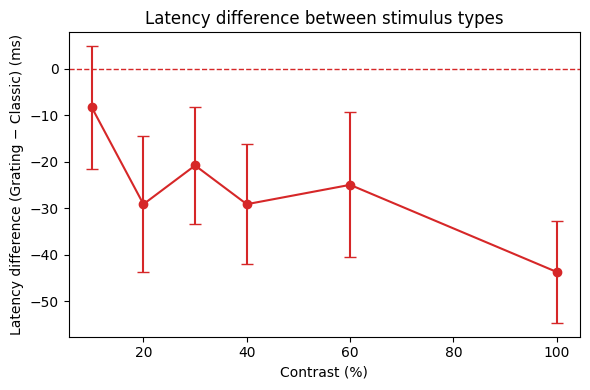

In [17]:
lat_summary = (diff_lat.groupby("contrast")["grating_minus_classic_latency_ms"].agg(["mean", "std", "count"]).reset_index())

lat_summary["sem"] = lat_summary["std"] / np.sqrt(lat_summary["count"])

plt.figure(figsize=(6,4))
plt.errorbar(
    lat_summary["contrast"],
    lat_summary["mean"],
    yerr=lat_summary["sem"],
    marker="o", color = 'C3', 
    capsize=4
)

plt.axhline(0, linestyle="--", linewidth=1, color='C3')
plt.xlabel("Contrast (%)")
plt.ylabel("Latency difference (Grating − Classic) (ms)")
plt.title("Latency difference between stimulus types")
plt.tight_layout()
plt.show()